High-Incidence Municipality Centrality: {'Villavicencio': 1.0, 'Neiva': 1.0, 'Ibagué': 1.0, 'Cali': 0.5555555555555556, 'Sincelejo': 0.8888888888888888, 'Cúcuta': 1.0, 'Valledupar': 0.8888888888888888, 'Bucaramanga': 1.0, 'Yopal': 0.8888888888888888, 'Cartagena de Indias': 0.8888888888888888}
High-Incidence Clustering Coefficient: 0.9444444444444444
Low-Incidence Municipality Centrality: {'Abejorral': 1.0, 'Alejandría': 1.0, 'Angelópolis': 1.0, 'Angostura': 1.0, 'Argelia': 1.0, 'Belmira': 1.0, 'Caicedo': 1.0, 'Campamento': 1.0, 'Caramanta': 1.0, 'El Carmen de Viboral': 1.0}
Low-Incidence Clustering Coefficient: 1.0


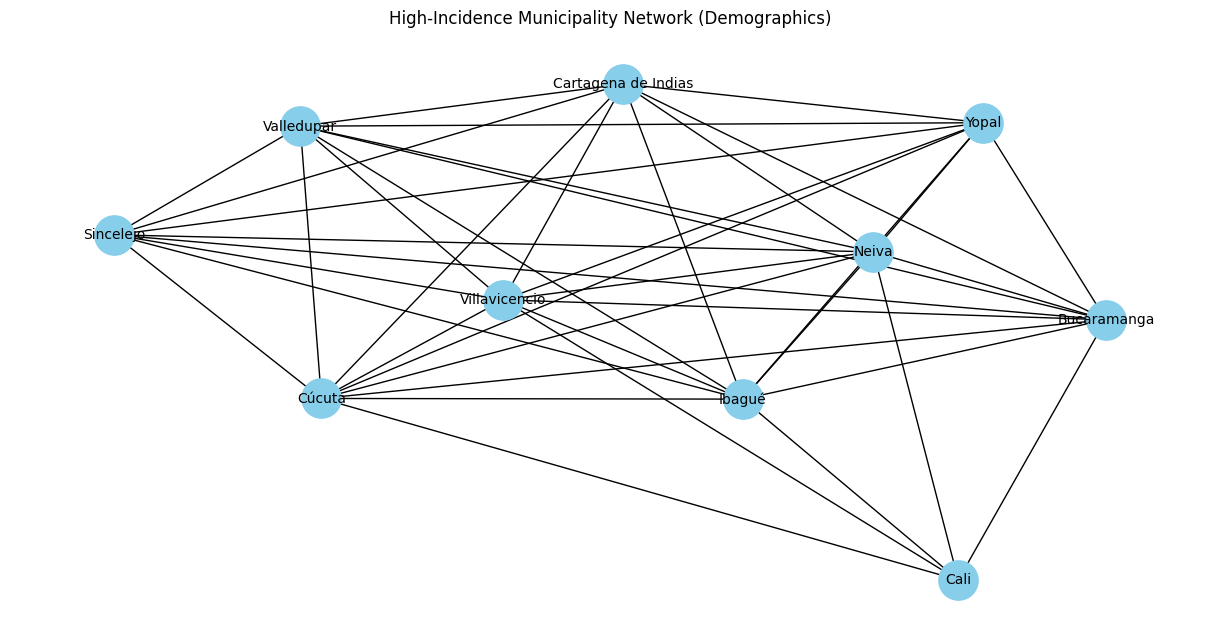

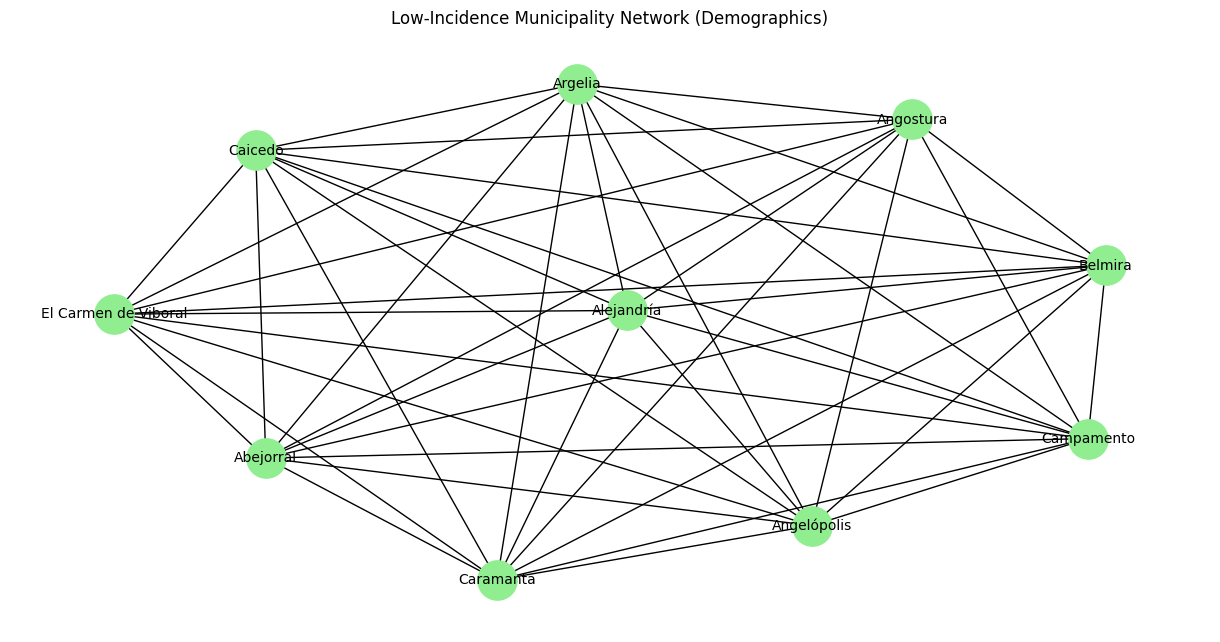

High-Incidence Demographics: {'Balanced': 9, 'Elderly': 6, 'Female-Dominant': 1, 'Adults': 4}
Low-Incidence Demographics: {'Balanced': 10, 'Elderly': 6, 'Adults': 4}


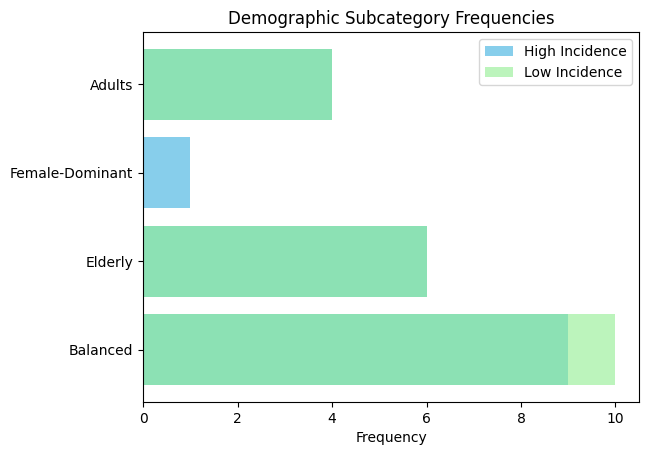

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("/Users/lilysorensen/Downloads/metadata.csv")

# Categorize Gender
def categorize_gender(men_percentage, women_percentage):
    ratio = men_percentage / women_percentage
    if ratio > 1.1:
        return "Male-Dominant"
    elif ratio < 0.9:
        return "Female-Dominant"
    else:
        return "Balanced"

# Categorize Age Groups
def categorize_age(age0_4, age5_14, age15_29, age30_plus):
    if age30_plus >= 50:
        return "Elderly"
    elif age15_29 + age30_plus >= 50:
        return "Adults"
    else:
        return "Youth"

# Add gender and age categories to the dataset
data["GenderCategory"] = data.apply(lambda row: categorize_gender(row["Men(%)"], row["Women(%)"]), axis=1)
data["AgeCategory"] = data.apply(
    lambda row: categorize_age(row["Age0-4(%)"], row["Age5-14(%)"], row["Age15-29(%)"], row["Age>30(%)"]), axis=1
)

# Separate municipalities into high and low dengue groups
high_incidence = data.nlargest(10, "Cases2019")
low_incidence = data.nsmallest(10, "Cases2019")

# Two-Mode Network Construction
def create_two_mode_network(municipalities):
    B = nx.Graph()
    for _, row in municipalities.iterrows():
        municipality = row["Municipality"]
        B.add_node(municipality, type="municipality")
        
        # Add demographic nodes and edges
        B.add_node(row["GenderCategory"], type="demographic")
        B.add_edge(municipality, row["GenderCategory"])
        
        B.add_node(row["AgeCategory"], type="demographic")
        B.add_edge(municipality, row["AgeCategory"])
    return B

# Create two-mode networks
B_high = create_two_mode_network(high_incidence)
B_low = create_two_mode_network(low_incidence)

# One-Mode Network Projection
def project_one_mode(bipartite_graph):
    municipalities = [n for n, d in bipartite_graph.nodes(data=True) if d["type"] == "municipality"]
    return nx.projected_graph(bipartite_graph, municipalities)

one_mode_high = project_one_mode(B_high)
one_mode_low = project_one_mode(B_low)

# Analyze Network Metrics
def analyze_network(network):
    centrality = nx.degree_centrality(network)
    clustering = nx.average_clustering(network)
    return centrality, clustering

high_centrality, high_clustering = analyze_network(one_mode_high)
low_centrality, low_clustering = analyze_network(one_mode_low)

# Print Network Metrics
print("High-Incidence Municipality Centrality:", high_centrality)
print("High-Incidence Clustering Coefficient:", high_clustering)

print("Low-Incidence Municipality Centrality:", low_centrality)
print("Low-Incidence Clustering Coefficient:", low_clustering)

# Visualize Networks
def visualize_network(network, title, node_color):
    plt.figure(figsize=(12, 6))
    pos = nx.spring_layout(network)
    nx.draw(network, pos, with_labels=True, node_color=node_color, node_size=800, font_size=10)
    plt.title(title)
    plt.show()

visualize_network(one_mode_high, "High-Incidence Municipality Network (Demographics)", "skyblue")
visualize_network(one_mode_low, "Low-Incidence Municipality Network (Demographics)", "lightgreen")

# Subcategory Analysis
def count_subcategories(bipartite_graph):
    demographics = [n for n, d in bipartite_graph.nodes(data=True) if d["type"] == "demographic"]
    return {category: len(list(bipartite_graph.neighbors(category))) for category in demographics}

high_demographics = count_subcategories(B_high)
low_demographics = count_subcategories(B_low)

print("High-Incidence Demographics:", high_demographics)
print("Low-Incidence Demographics:", low_demographics)

# Compare Subcategory Frequencies
high_labels, high_values = zip(*high_demographics.items())
low_labels, low_values = zip(*low_demographics.items())

plt.barh(high_labels, high_values, color="skyblue", label="High Incidence")
plt.barh(low_labels, low_values, color="lightgreen", alpha=0.6, label="Low Incidence")
plt.xlabel("Frequency")
plt.title("Demographic Subcategory Frequencies")
plt.legend()
plt.show()
